# Environment Setup

In [15]:
# Install Required Libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install transformers networkx matplotlib scikit-learn tqdm
!pip install pyg-lib torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cpu.html



Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html


# Import Libraries

In [16]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout, LayerNorm
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, TransformerConv, Node2Vec
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Load & Explore Dataset

In [17]:
# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Print dataset details
print(f"Dataset: {dataset.name}")
print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges}")
print(f"Features: {data.num_node_features}, Classes: {dataset.num_classes}")
print(f"Train Nodes: {data.train_mask.sum().item()}, Val Nodes: {data.val_mask.sum().item()}, Test Nodes: {data.test_mask.sum().item()}")


Dataset: Cora
Nodes: 2708, Edges: 10556
Features: 1433, Classes: 7
Train Nodes: 140, Val Nodes: 500, Test Nodes: 1000


# Visualize Graph Structure

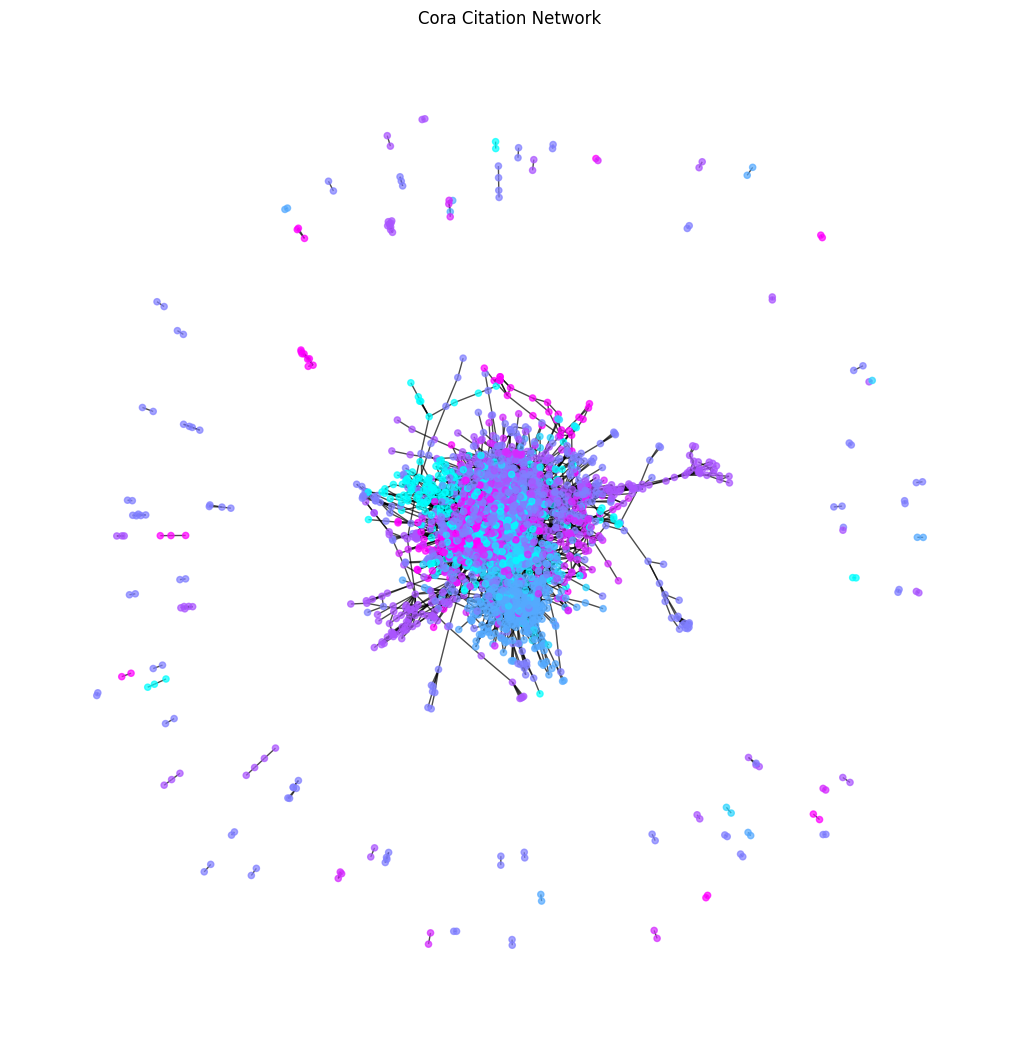

In [18]:
# Convert graph to NetworkX for visualization
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10, 10))
nx.draw(G, node_size=20, node_color=data.y.numpy(), cmap='cool', alpha=0.7)
plt.title("Cora Citation Network")
plt.show()


# Feature Engineering with PCA

In [19]:
# Apply PCA to reduce feature dimensions from 1433 to 256
pca = PCA(n_components=256)
data.x = torch.tensor(pca.fit_transform(data.x.numpy()), dtype=torch.float)

print(f"Reduced feature dimensions: {data.x.shape[1]}")


Reduced feature dimensions: 256


# Add Node2Vec Embeddings

In [20]:
!pip install node2vec


In [21]:
from node2vec import Node2Vec
import networkx as nx
import numpy as np
import torch

# Convert PyG graph to NetworkX format
G = to_networkx(data, to_undirected=True)

# Generate Node2Vec embeddings using networkx-node2vec
node2vec = Node2Vec(G, dimensions=128, walk_length=20, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Convert embeddings to tensor
node_embeddings = []
for node_id in range(data.num_nodes):
    node_embeddings.append(model.wv[str(node_id)])

node_embeddings = torch.tensor(np.array(node_embeddings), dtype=torch.float)

# Append these embeddings to the existing node features
data.x = torch.cat([data.x, node_embeddings], dim=1)

print(f"New feature dimensions after Node2Vec embeddings: {data.x.shape[1]}")


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
class BalancedGCNTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super(BalancedGCNTransformer, self).__init__()

        # Initial GCN Layer
        self.gcn = GCNConv(in_channels, hidden_channels)

        # Transformer Layers
        self.transformer1 = TransformerConv(hidden_channels, hidden_channels // heads, heads=heads)
        self.transformer2 = TransformerConv(hidden_channels, hidden_channels // heads, heads=heads)

        # MLP Classifier
        self.fc1 = Linear(hidden_channels, 64)
        self.fc2 = Linear(64, out_channels)

        # Regularization
        self.dropout = Dropout(0.6)
        self.layer_norm = LayerNorm(hidden_channels)

    def forward(self, x, edge_index):
        # Step 1: Apply GCN (local structure)
        x = F.relu(self.gcn(x, edge_index))
        x = self.dropout(x)

        # Step 2: Apply Transformer layers with LayerNorm
        x = F.relu(self.transformer1(x, edge_index))
        x = self.layer_norm(x)
        x = self.dropout(x)

        x = F.relu(self.transformer2(x, edge_index))
        x = self.layer_norm(x)
        x = self.dropout(x)

        # Step 3: Classification
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [23]:
# Initialize model, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BalancedGCNTransformer(
    in_channels=data.x.shape[1],
    hidden_channels=128,
    out_channels=dataset.num_classes,
    heads=2
).to(device)

data = data.to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=15)


In [24]:
best_val_acc = 0
patience = 20
counter = 0
logs = []

for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        val_pred = out[data.val_mask].argmax(dim=1)
        val_acc = (val_pred == data.y[data.val_mask]).float().mean().item()

        test_pred = out[data.test_mask].argmax(dim=1)
        test_acc = (test_pred == data.y[data.test_mask]).float().mean().item()

    logs.append((epoch, val_acc, test_acc))

    # Track best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
    else:
        counter += 1

    # Apply learning rate scheduler
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")

    # Stop training if no improvement
    if counter >= patience:
        print("Early stopping triggered.")
        break


Epoch 1: Loss=2.0490, Val Acc=0.1840, Test Acc=0.1820
Epoch 2: Loss=1.9695, Val Acc=0.1480, Test Acc=0.1460
Epoch 3: Loss=1.9605, Val Acc=0.1760, Test Acc=0.1250
Epoch 4: Loss=1.9615, Val Acc=0.1200, Test Acc=0.1080
Epoch 5: Loss=1.9296, Val Acc=0.1260, Test Acc=0.1160
Epoch 6: Loss=1.9784, Val Acc=0.1460, Test Acc=0.1260
Epoch 7: Loss=1.9706, Val Acc=0.1180, Test Acc=0.1410
Epoch 8: Loss=1.9630, Val Acc=0.1400, Test Acc=0.1500
Epoch 9: Loss=1.9621, Val Acc=0.1700, Test Acc=0.1640
Epoch 10: Loss=1.9702, Val Acc=0.1540, Test Acc=0.1750
Epoch 11: Loss=1.9492, Val Acc=0.1900, Test Acc=0.1690
Epoch 12: Loss=1.9748, Val Acc=0.1580, Test Acc=0.1720
Epoch 13: Loss=1.9367, Val Acc=0.1840, Test Acc=0.1900
Epoch 14: Loss=1.9407, Val Acc=0.1840, Test Acc=0.1580
Epoch 15: Loss=1.9264, Val Acc=0.1920, Test Acc=0.1980
Epoch 16: Loss=1.9404, Val Acc=0.1800, Test Acc=0.1910
Epoch 17: Loss=1.9320, Val Acc=0.1800, Test Acc=0.1790
Epoch 18: Loss=1.9327, Val Acc=0.1960, Test Acc=0.1810
Epoch 19: Loss=1.90

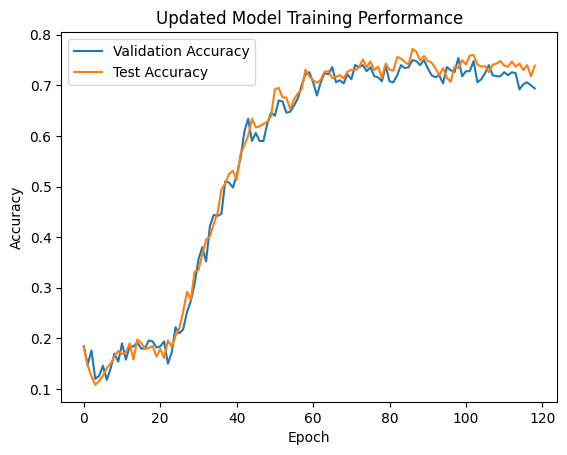

In [25]:
epochs, val_accs, test_accs = zip(*logs)

plt.plot(epochs, val_accs, label="Validation Accuracy")
plt.plot(epochs, test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Updated Model Training Performance")
plt.legend()
plt.show()
